In [1]:
import os

import calliope
import matplotlib.pyplot as plt
import seaborn as sns

calliope.set_log_verbosity("warning")

inputdir = "/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_2/2.3_shared/euro-calliope-uk_irl_2"
outputdir = "~/outputs"
calliope.set_log_verbosity("warning")

if "GRB_LICENSE_FILE" not in os.environ.keys():
    os.environ["GRB_LICENSE_FILE"] = "/gws/smf/j04/cop26_hackathons/oxford/gurobi/gurobi.lic"

In [2]:
model = calliope.Model(
    os.path.join(inputdir, "national_AWD", "example-model.yaml"), 
    scenario="freeze-hydro-capacities"
)

In [3]:
model.run()

[2021-06-25 07:02:46] INFO     Loading sets
[2021-06-25 07:02:46] INFO     Loading parameters
[2021-06-25 07:02:47] INFO     constraints are loaded in the following order: ['capacity', 'costs', 'dispatch', 'energy_balance', 'network', 'policy', 'conversion', 'conversion_plus', 'group', 'export', 'milp']
[2021-06-25 07:02:47] INFO     creating capacity constraints
[2021-06-25 07:02:47] INFO     creating costs constraints
[2021-06-25 07:02:48] INFO     creating dispatch constraints
[2021-06-25 07:02:49] INFO     creating energy_balance constraints
[2021-06-25 07:02:50] INFO     creating network constraints
[2021-06-25 07:02:50] INFO     creating policy constraints
[2021-06-25 07:02:50] INFO     creating conversion constraints
[2021-06-25 07:02:50] INFO     creating conversion_plus constraints
[2021-06-25 07:02:50] INFO     creating group constraints
[2021-06-25 07:02:50] INFO     creating export constraints
[2021-06-25 07:02:50] INFO     creating milp constraints
[2021-06-25 07:02:50] DE

In [26]:
def update_model_capacities(optimal_model, new_model, fillna=False):
    if fillna is True:
        new_model._model_data["energy_cap_equals"] = (
            new_model._model_data["energy_cap_equals"].fillna(
                optimal_model._model_data["energy_cap"]
                .where(optimal_model._model_data.loc_techs.str.find("demand") == -1)
            )
        )
        new_model._model_data["storage_cap_equals"] = (
            new_model._model_data["storage_cap_equals"].fillna(
                optimal_model._model_data["storage_cap"]
            )
        )
    else:
        new_model._model_data["energy_cap_equals"] = (
            optimal_model._model_data["energy_cap"]
            .where(optimal_model._model_data.loc_techs.str.find("demand") == -1)
        )
        new_model._model_data["storage_cap_equals"] = optimal_model._model_data["storage_cap"]

    new_model._model_data["energy_cap_equals"].attrs["is_result"] = 0
    new_model._model_data["storage_cap_equals"].attrs["is_result"] = 0

In [48]:
new_model = calliope.Model(
    os.path.join(inputdir, "national_AWD", "example-model1.yaml"), 
    scenario="freeze-hydro-capacities,dispatch,load-shedding"
)
update_model_capacities(model, new_model, fillna=True)

In [49]:
new_model.run()

[2021-06-25 08:58:52] WARNING  /home/users/train015/.conda/envs/euro-calliope/lib/python3.7/site-packages/calliope/exceptions.py:60: ModelWarning:

Possible issues found during model processing:
 * Initial stored energy not defined, set to zero for all loc::techs in loc_techs_store, for use in iterative optimisation
 * Resource capacity constraint defined and set to infinity for all supply_plus techs


[2021-06-25 08:58:52] INFO     Loading sets
[2021-06-25 08:58:52] INFO     Loading parameters
[2021-06-25 08:58:53] INFO     constraints are loaded in the following order: ['capacity', 'costs', 'dispatch', 'energy_balance', 'network', 'policy', 'conversion', 'conversion_plus', 'group', 'export', 'milp']
[2021-06-25 08:58:53] INFO     creating capacity constraints
[2021-06-25 08:58:53] INFO     creating costs constraints
[2021-06-25 08:58:54] INFO     creating dispatch constraints
[2021-06-25 08:58:54] INFO     creating energy_balance constraints
[2021-06-25 08:58:55] INFO     creating ne

In [50]:
#Number of customers served - currently redundant
customers = 40000000

#Get the load shedding timeseries data to an array called df
df = new_model.get_formatted_array("carrier_prod").loc[{"techs": "load_shedding"}].to_series().dropna()
print(df)

#Get the load timeseries
df_load = new_model.get_formatted_array("carrier_con").loc[{"techs": "demand_elec"}].to_series().dropna()
print(df_load)

#Calculate Expected Energy Not Supplied by adding up all load shedding energy
EENS = df.sum()

#Express load shedding (df) as a fraction of load (df_load), then multiply with customers - this gives an estimate of the customers affected
df.loc[df > 0] = (df / abs(df_load)) * customers
df.loc[df == float('inf')] = 0.0
df.loc[df <= 0] = 0.0

#Take the sum of all customers affected per instance, then divide with total customers, to get SAIFI = Σ(λ_i*N_i)/N_T.
#Interruptions = df.apply(lambda x : True if x > 0 else False)
#num_interruptions = len(Interruptions[Interruptions==True].index)
SAIFI = df.sum() / customers
SAIFI

#Multiply SAIFI with the timestep (currently 24h), to get the duration
SAIDI = SAIFI * 24
SAIDI

#Calculate ASUI
ASUI = SAIDI / 8760
ASUI

#Print all reliability indices
print('EENS =',EENS,';  SAIFI =',SAIFI,';  SAIDI =',SAIDI,';  ASUI =',ASUI)

carriers     locs  timesteps 
electricity  GBR   2016-01-01    0.000000
                   2016-01-02    0.000000
                   2016-01-03    0.000000
                   2016-01-04    0.000000
                   2016-01-05    0.000000
                                   ...   
             IRL   2016-12-27    0.000760
                   2016-12-28    0.000738
                   2016-12-29    0.000686
                   2016-12-30    0.000817
                   2016-12-31    0.000746
Name: carrier_prod, Length: 730, dtype: float64
carriers     locs  timesteps 
electricity  GBR   2016-01-01   -0.040611
                   2016-01-02   -0.039960
                   2016-01-03   -0.041501
                   2016-01-04   -0.042561
                   2016-01-05   -0.042805
                                   ...   
             IRL   2016-12-27   -0.003458
                   2016-12-28   -0.003449
                   2016-12-29   -0.003406
                   2016-12-30   -0.003544
          

[2021-06-25 09:25:47] INFO     Model: initialising
[2021-06-25 09:25:47] INFO     Applying the following overrides from scenario definition: ['dispatch', 'freeze-hydro-capacities', 'load-shedding'] 
[2021-06-25 09:25:47] INFO     `locations.GBR.techs.hydro_reservoir.constraints.energy_cap_equals`:0.005240000000000001 applied from override as new configuration
`locations.GBR.techs.hydro_reservoir.constraints.storage_cap_equals`:4.719944197044335 applied from override as new configuration
`locations.GBR.techs.hydro_run_of_river.constraints.energy_cap_equals`:0.008484750000000003 applied from override as new configuration
`locations.GBR.techs.load_shedding`:None applied from override as new configuration
`locations.GBR.techs.pumped_hydro.constraints.energy_cap_equals`:0.029050000000000003 applied from override as new configuration
`locations.GBR.techs.pumped_hydro.constraints.storage_cap_equals`:0.267 applied from override as new configuration
`locations.IRL.techs.hydro_reservoir.constrai

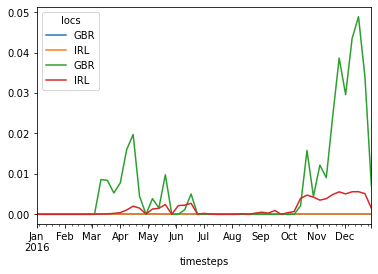

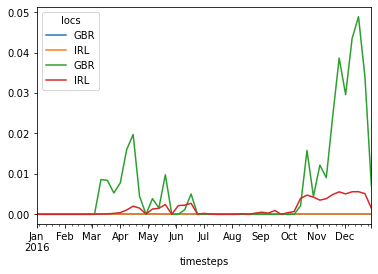

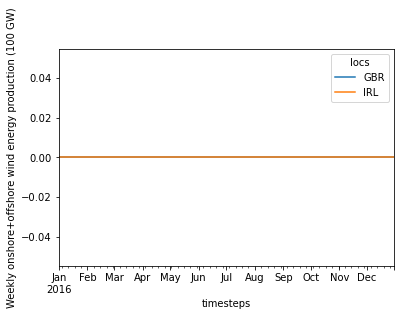

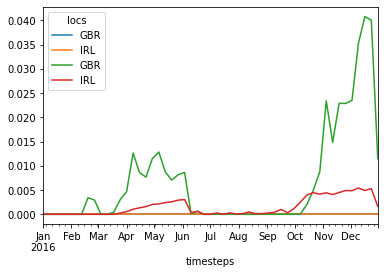

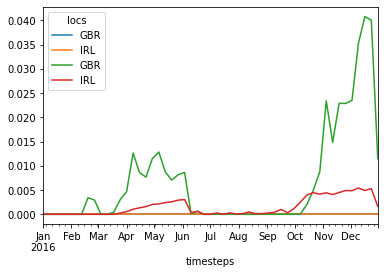

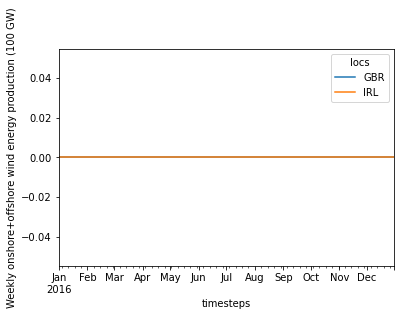

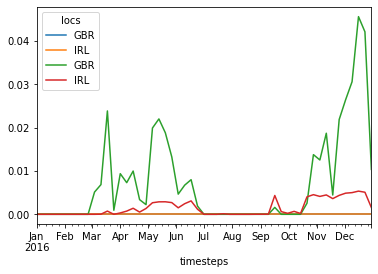

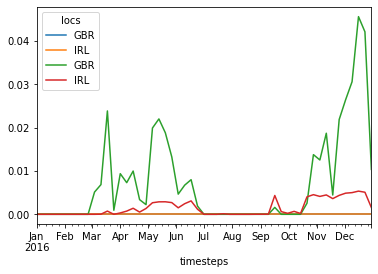

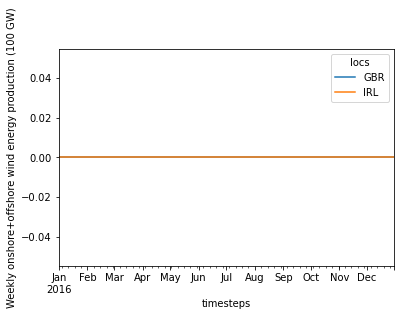

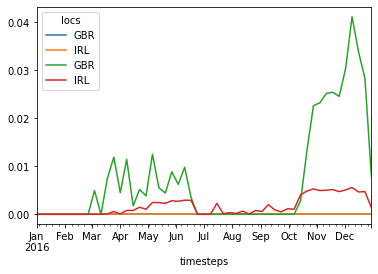

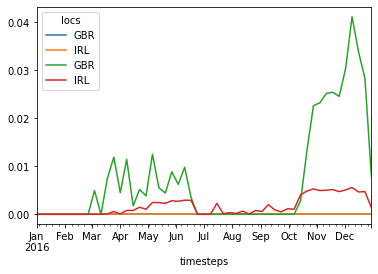

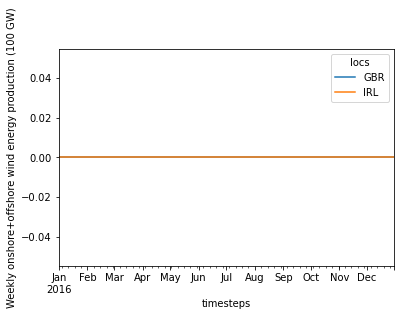

In [59]:
import numpy as np

no_of_years = 4
# We have (1):1/100yr event, (2):1/50yr event, (3):1/20yr event, (4):extreme event

EENS = np.zeros(no_of_years)
SAIFI = np.zeros(no_of_years)
SAIDI = np.zeros(no_of_years)
ASUI = np.zeros(no_of_years)

inputdir = "/gws/pw/j05/cop26_hackathons/oxford/Group_folders/group_2/2.3_shared/euro-calliope-uk_irl_2"
    
#Looping
for x in range(0,no_of_years):
    new_model = calliope.Model(
        os.path.join(inputdir, "national_AWD", "example-model"+str(x+1)+".yaml"),
        #os.path.join(inputdir, "national_AWD", "example-model.yaml"), 
        scenario="freeze-hydro-capacities,dispatch,load-shedding"
    )
    update_model_capacities(model, new_model, fillna=True)
    
    calliope.set_log_verbosity(verbosity='info', include_solver_output=False, capture_warnings=True)
    new_model.run()
    
    energy_production = new_model.get_formatted_array("carrier_prod").to_series().dropna()
    wind = (
        energy_production[energy_production.index.get_level_values("techs").str.find("wind") > -1]
        .sum(level=["locs", "timesteps"])
        .unstack("locs")
    )
    wind_7D_sum = wind.resample("7D").sum()
    ax = wind_7D_sum.plot()

    energy_production.xs("load_shedding", level="techs").droplevel("carriers").unstack("locs").resample("7D").sum().plot(ax=ax)
    
    # look time series
    energy_production = new_model.get_formatted_array("carrier_prod").to_series().dropna()
    wind = (
        energy_production[energy_production.index.get_level_values("techs").str.find("wind") > -1]
        .sum(level=["locs", "timesteps"])
        .unstack("locs")
    )
    wind_7D_sum = wind.resample("7D").sum()
    ax = wind_7D_sum.plot()

    energy_production.xs("load_shedding", level="techs").droplevel("carriers").unstack("locs").resample("7D").sum().plot(ax=ax)
    
    
    # Energy production, units = 100 GWh (summed over three hours)
    energy_production = model.get_formatted_array("carrier_prod").to_series().dropna()
    # Wind production
    wind = (
        energy_production[energy_production.index.get_level_values("techs").str.find("wind") > -1]
        .sum(level=["locs", "timesteps"])
        .unstack("locs")
    )
    print(wind.head())
    wind_7D_sum = wind.resample("7D").sum()
    ax = wind_7D_sum.plot()
    ax.set_ylabel("Weekly onshore+offshore wind energy production (100 GW)")
    
    #Number of customers served - currently redundant
    customers = 40000000

    #Get the load shedding timeseries data to an array called df
    df = new_model.get_formatted_array("carrier_prod").loc[{"techs": "load_shedding"}].to_series().dropna()
    print(df)

    #Get the load timeseries
    df_load = new_model.get_formatted_array("carrier_con").loc[{"techs": "demand_elec"}].to_series().dropna()
    print(df_load)

    #Calculate Expected Energy Not Supplied by adding up all load shedding energy
    EENS[x] = df.sum()

    #Express load shedding (df) as a fraction of load (df_load), then multiply with customers - this gives an estimate of the customers affected
    df.loc[df > 0] = (df / abs(df_load)) * customers
    df.loc[df == float('inf')] = 0.0
    df.loc[df <= 0] = 0.0

    #Take the sum of all customers affected per instance, then divide with total customers, to get SAIFI = Σ(λ_i*N_i)/N_T.
    #Interruptions = df.apply(lambda x : True if x > 0 else False)
    #num_interruptions = len(Interruptions[Interruptions==True].index)
    SAIFI[x] = df.sum() / customers
    SAIFI[x]

    #Multiply SAIFI with the timestep (currently 24h), to get the duration
    SAIDI[x] = SAIFI[x] * 24
    SAIDI[x]

    #Calculate ASUI
    ASUI[x] = SAIDI[x] / 8760
    ASUI[x]

    #Print all reliability indices
    print('EENS =',EENS)
    print('SAIFI =',SAIFI)
    print('SAIDI =',SAIDI)
    print('ASUI =',ASUI)

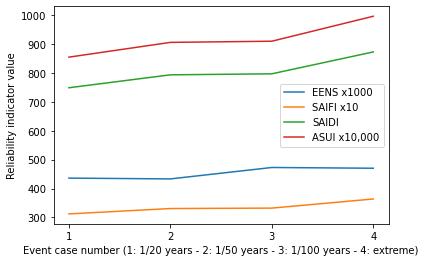

In [104]:
xval=[1,2,3,4]
plt.plot(xval,EENS*1000, label='EENS x1000')
plt.plot(xval,SAIFI*10, label='SAIFI x10')
plt.plot(xval,SAIDI, label='SAIDI')
plt.plot(xval,ASUI*10000, label='ASUI x10,000')
plt.xticks(xval)
plt.xlabel("Event case number (1: 1/20 years - 2: 1/50 years - 3: 1/100 years - 4: extreme)")
plt.ylabel("Reliability indicator value")
plt.legend()
plt.show()